In [1]:
import pandas as pd


In [3]:
pwd

'/Users/admin/Desktop/NTU/Y2Sem2/SD6103_Data_Preparation/dataprep_project/notebooks/selene'

In [4]:
df = pd.read_csv("Food_Inspections_20250216.csv")
df.info()
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287237 entries, 0 to 287236
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    287237 non-null  int64  
 1   DBA Name         287237 non-null  object 
 2   AKA Name         284811 non-null  object 
 3   License #        287219 non-null  float64
 4   Facility Type    282040 non-null  object 
 5   Risk             287149 non-null  object 
 6   Address          287237 non-null  object 
 7   City             287073 non-null  object 
 8   State            287179 non-null  object 
 9   Zip              287198 non-null  float64
 10  Inspection Date  287237 non-null  object 
 11  Inspection Type  287236 non-null  object 
 12  Results          287237 non-null  object 
 13  Violations       207585 non-null  object 
 14  Latitude         286259 non-null  float64
 15  Longitude        286259 non-null  float64
 16  Location         286259 non-null  obje

In [77]:
import numpy as np


def first_digit_distribution(series):
    """
    Returns the distribution of the first digit (1-9) in numeric values of `series`.
    Useful for a rough check against Benford's law.
    """
    
    # Drop NA
    s = series.dropna()
    
    # Convert to string
    s_str = s.astype(str)
    
    # Extract the first character that is a digit (ignoring sign or leading spaces)
    first_digits = []
    for val in s_str:
        # Remove leading signs/spaces
        val = val.lstrip(" -+0")  # remove leading '-', '+', ' ', and '0'
        if val and val[0].isdigit():
            first_digits.append(val[0])
    
    # Count first digit frequencies
    digit_counts = pd.value_counts(first_digits, sort=False)
    
    # Convert to proportions
    digit_dist = digit_counts / digit_counts.sum()
    return digit_dist

def profile_column(series, numeric_bins=10):
    """
    Profiles a single column (`series`) and returns a dictionary of metrics.
    """
    col_profile = {}
    
    # Basic stats
    num_rows = len(series)
    col_profile['num_rows'] = num_rows
    
    # Null values
    null_count = series.isna().sum()
    null_pct = null_count / num_rows if num_rows > 0 else np.nan
    col_profile['null_count'] = null_count
    col_profile['null_pct'] = null_pct
    
    # Distinct / uniqueness
    distinct_count = series.nunique(dropna=False)
    col_profile['distinct_count'] = distinct_count
    col_profile['uniqueness'] = distinct_count / num_rows if num_rows > 0 else np.nan
    
    # Constancy
    # Frequency of most frequent value
    if num_rows > 0:
        most_freq = series.value_counts(dropna=False).iloc[0]
        col_profile['constancy'] = most_freq / num_rows
    else:
        col_profile['constancy'] = np.nan
    
    # Try to determine if column is numeric
    # Convert to numeric (coerce errors to NaN) and see how many non-NaN we get:
    numeric_series = pd.to_numeric(series, errors='coerce')
    num_notna = numeric_series.notna().sum()
    is_numeric = (num_notna / num_rows) > 0.9  # heuristic: if >90% can convert to numeric
    
    if is_numeric:
        # Numeric column profiling
        # 1) quartiles
        col_profile['quartiles'] = numeric_series.quantile([0.25, 0.5, 0.75]).to_dict()
        
        # 2) histogram (equi-width)
        # Using numpy histogram by default with 10 bins
        hist_counts, bin_edges = np.histogram(numeric_series.dropna(), bins=numeric_bins)
        col_profile['histogram_equi_width'] = {
            'bin_edges': bin_edges.tolist(),
            'counts': hist_counts.tolist()
        }
        
        # Optionally, equi-depth histogram: we can use qcut
        # (Same as dividing data points into quantiles)
        try:
            # 10 quantile-based bins, example
            qlabels = [f"bin_{i+1}" for i in range(numeric_bins)]
            qcut_series = pd.qcut(numeric_series.dropna(), q=numeric_bins, labels=qlabels)
            col_profile['histogram_equi_depth'] = qcut_series.value_counts().to_dict()
        except ValueError:
            # This can fail if there are too few unique values or data is all the same
            col_profile['histogram_equi_depth'] = "Not enough numeric variety for qcut."
        
        # 3) First digit distribution
        col_profile['first_digit_distribution'] = first_digit_distribution(numeric_series).to_dict()
        
    else:
        # Non-numeric / string column
        # 1) length measurements: note this is character lengths, not counts of values:
        # Convert to string, get length
        lengths = series.dropna().astype(str).apply(len)
        
        if len(lengths) > 0:
            col_profile['length_min'] = lengths.min()
            col_profile['length_max'] = lengths.max()
            col_profile['length_median'] = lengths.median()
            col_profile['length_mean'] = lengths.mean()
        else:
            col_profile['length_min'] = np.nan
            col_profile['length_max'] = np.nan
            col_profile['length_median'] = np.nan
            col_profile['length_mean'] = np.nan
        
        # 2) histogram (categorical)
        # For a categorical histogram, we typically look at the value counts
        # (but be careful with very high cardinality)
        value_counts = series.value_counts(dropna=False)
        col_profile['histogram'] = value_counts.to_dict()
    
    return col_profile


profiles = {}
for col in df.columns:
    profiles[col] = profile_column(df[col])
profile_df = pd.DataFrame(profiles).T  

/var/folders/bg/1y0v_kw15cnb9w8c866jb_280000gn/T/ipykernel_41062/2419342840.py:27: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  digit_counts = pd.value_counts(first_digits, sort=False)
/var/folders/bg/1y0v_kw15cnb9w8c866jb_280000gn/T/ipykernel_41062/2419342840.py:27: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  digit_counts = pd.value_counts(first_digits, sort=False)
/var/folders/bg/1y0v_kw15cnb9w8c866jb_280000gn/T/ipykernel_41062/2419342840.py:27: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  digit_counts = pd.value_counts(first_digits, sort=False)
/var/folders/bg/1y0v_kw15cnb9w8c866jb_280000gn/T/ipykernel_41062/2419342840.py:27: FutureWarning: value_counts with argument that is not not a Series, In

In [78]:
profile_df

,num_rows,null_count,null_pct,distinct_count,uniqueness,constancy,quartiles,histogram_equi_width,histogram_equi_depth,first_digit_distribution,length_min,length_max,length_median,length_mean,histogram
Inspection ID,287237,0,0.0,287237,1.0,0.000003,"{0.25: 1327178.0, 0.5: 1981286.0, 0.75: 247277...","{'bin_edges': [44247.0, 301045.0, 557843.0, 81...","{'bin_1': 28724, 'bin_2': 28724, 'bin_4': 2872...","{'1': 0.3851488492081452, '2': 0.5058087920428...",NaN,NaN,NaN,NaN,NaN
DBA Name,287237,0,0.0,33304,0.115946,0.013149,NaN,NaN,NaN,NaN,1,79,18.0,18.748291,"{'SUBWAY': 3777, 'DUNKIN DONUTS': 1998, 'MCDON..."
AKA Name,287237,2426,0.008446,31704,0.110376,0.016175,NaN,NaN,NaN,NaN,2,79,17.0,17.906348,"{'SUBWAY': 4646, nan: 2426, 'DUNKIN DONUTS': 1..."
License #,287237,18,0.000063,46275,0.161104,0.002587,"{0.25: 1379974.0, 0.5: 2069431.0, 0.75: 241118...","{'bin_edges': [0.0, 999999.9, 1999999.8, 29999...","{'bin_5': 28734, 'bin_9': 28728, 'bin_2': 2872...","{'2': 0.603956352364596, '1': 0.28293469610019...",NaN,NaN,NaN,NaN,NaN
Facility Type,287237,5197,0.018093,520,0.00181,0.674896,NaN,NaN,NaN,NaN,3,47,10.0,11.117997,"{'Restaurant': 193855, 'Grocery Store': 35214,..."
Risk,287237,88,0.000306,5,0.000017,0.737234,NaN,NaN,NaN,NaN,3,15,13.0,13.282226,"{'Risk 1 (High)': 211761, 'Risk 2 (Medium)': 5..."
Address,287237,0,0.0,30905,0.107594,0.010643,NaN,NaN,NaN,NaN,1,52,18.0,18.50545,"{'11601 W TOUHY AVE ': 3057, '5700 S CICERO AV..."
City,287237,164,0.000571,87,0.000303,0.996049,NaN,NaN,NaN,NaN,2,20,7.0,7.002829,"{'CHICAGO': 286102, 'Chicago': 448, nan: 164, ..."
State,287237,58,0.000202,7,0.000024,0.999746,NaN,NaN,NaN,NaN,2,2,2.0,2.0,"{'IL': 287164, nan: 58, 'IN': 10, 'CA': 2, 'CO..."
Zip,287237,39,0.000136,128,0.000446,0.037098,"{0.25: 60614.0, 0.5: 60625.0, 0.75: 60643.0}","{'bin_edges': [10014.0, 18063.0, 26112.0, 3416...","{'bin_1': 37066, 'bin_3': 32388, 'bin_7': 3213...","{'6': 0.9999477712240336, '8': 3.4819183977604...",NaN,NaN,NaN,NaN,NaN


# Some observations:

Null values:
- Violations (27.7%) have the highest null values, while the remaining columns with null values have less than 2% null values. 

Uniqueness:
- Inspection ID is fully unique
- Other columns have low uniqueness but are not 0, suggesting repeated values. This is expected as there are re-inspections or further inspections that are entered as separate rows. This can be checked again in multi-column profiling and FDs

Constancy:
- some columns showing very high constancy include city and state (most inspections are likely done in these city/state) -> skewness


In [22]:
import matplotlib.pyplot as plt

# First Digit Distribution

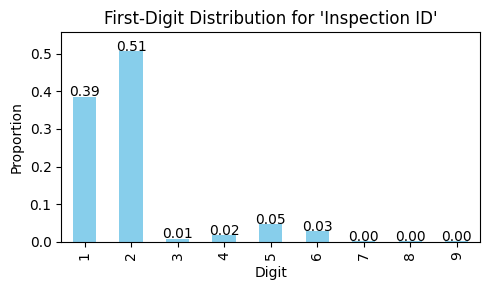

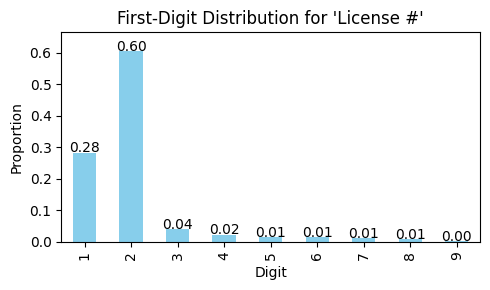

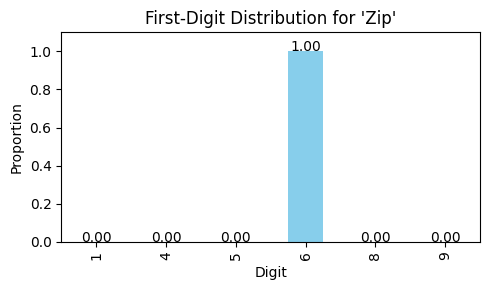

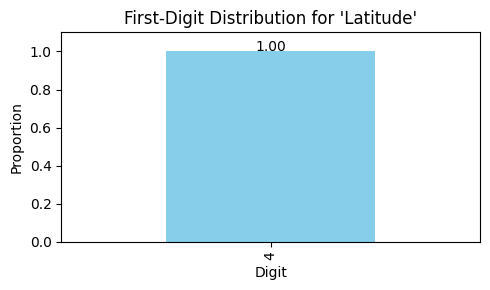

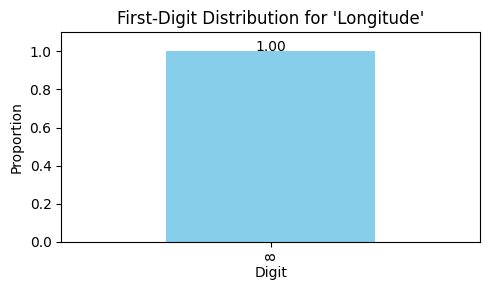

In [112]:
for idx, row in profile_df.iterrows():
    dist_dict = row["first_digit_distribution"]
    
    # Check if this row is non-NA:
    if isinstance(dist_dict, dict) and len(dist_dict) > 0:
        # Convert dictionary to a Series:
        digit_series = pd.Series(dist_dict)
        
        # sorting keys:
        digit_series = digit_series.reindex(sorted(digit_series.index, key=int))
        
        # Plot
        plt.figure(figsize=(5, 3))
        digit_series.plot(kind="bar", color="skyblue")
        
        # Title can refer to the row index or to some descriptive column in profile_df
        plt.title(f"First-Digit Distribution for '{idx}'")
        plt.xlabel("Digit")
        plt.ylabel("Proportion")
        
        # Optionally show the proportions on top of each bar
        for x, y in enumerate(digit_series.values):
            plt.text(x, y + 0.001, f"{y:.2f}", ha='center')
        
        plt.ylim(0, max(digit_series.values) * 1.1)  # give some space at top
        plt.tight_layout()
        plt.show()

# Profiling Text Data (value distributions)
Distinct counts of text columns DBA Name, AKA Name, Address, Violations and locations are quite high (>18000), thus analysing value distributions via patterns may be more suitable. Value distributions of columns facility type, risk, city, state, inspection type, and results are still permissible. 

In [24]:
import matplotlib.pyplot as plt

# Columns to process
text_columns_small = [
    "Facility Type", "Risk", "City", "State", "Inspection Type", "Results"
]

# Dictionary to hold frequency DataFrames, keyed by column name
freq_dfs = {}

for col in text_columns_small:
    # Create a frequency table (value_counts) and turn it into a DataFrame
    freq_df = (
        df[col]
        .value_counts(dropna=False)        # Count frequencies (including NaN as a category)
        .rename_axis("value")             # Rename the index to "value"
        .reset_index(name="count")        # Create a column "count"
    )
    
    #rename columns for clarity
    freq_df.columns = [f"{col}_value", f"{col}_count"]
    
    # Dictionary:
    freq_dfs[col] = freq_df
    
    
# Now you have a dictionary of DataFrames (freq_dfs[col]),
# each containing the frequencies for that particular column.



# Columns to drop (for Association rule and FD):
- AKA name
- Inspection ID
- Latitude
- Longitude



# fuzzy matching first:
- facility type 
- city (1. capitalise everything first to reduce fuzzy matching, 2. fuzzy matching to resolve chicago, 3. Drop all cities that are not 'CHICAGO' )
- address - higher threshold? (1. capitalise everything first, 2. fuzzy matching)
- Inspection type (see whether can do eyeball?)


# State:
- drop all states that are not 'IL'


# columns relevant for FD/association rule:
- license #
- facility type
- Risk
- Address
- City
- State
- Zip
- Inspection Date
- Inspection Type
- Results
- Location


# rows with NA/nulls:
- drop the rows? if NAs exist in values that are not relevant, no need to drop (e.g., a  row has null only for AKA name, but the remaining columns are non-NA, then no need to drop)

In [44]:
df

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violation_codes,Violation_code_count
0,1106427,BLOOMING BUD DAYCARE,BLOOMING BUD DAYCARE,2215789.0,Daycare Combo 1586,Risk 1 (High),5715 N LINCOLN AVE,CHICAGO,IL,60659.0,03/07/2013,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.985390,-87.698734,"(41.98538950526786, -87.69873407149943)","{35, 32, 34}",3
1,2608378,Babas Halal,Babas Halal,2684170.0,Restaurant,Risk 1 (High),7901 S DAMEN AVE,CHICAGO,IL,60620.0,12/03/2024,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.750189,-87.672986,"(41.750189342293375, -87.67298583977204)","{41, 22, 21, 61, 201, 50, 10, 20, 204, 101, 50...",28
2,1106406,FIRST ZABIHA MEAT BAZAAR,FIRST ZABIHA MEAT BAZAAR,2232559.0,Grocery Store,Risk 2 (Medium),2907 W DEVON AVE,CHICAGO,IL,60659.0,02/20/2013,License,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.997401,-87.702385,"(41.99740137039031, -87.70238538227812)","{38, 30, 11, 32, 42, 33, 34, 35}",8
3,2609909,HAPPY MARKET,HAPPY MARKET,2912802.0,Grocery Store,Risk 2 (Medium),2334 S WENTWORTH AVE,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.849954,-87.632094,"(41.84995400192252, -87.63209419559098)","{38, 49, 501, 301, 2, 10}",6
4,2609927,SAT KAIVAL FOOD INC/SUBWAY,SAT KAIVAL FOOD INC/SUBWAY,2728400.0,Restaurant,Risk 1 (High),1916 S STATE ST,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.856053,-87.627311,"(41.85605269621059, -87.62731125804903)","{53, 36}",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287232,2610937,DAPPER'S EAST RESTAURANT,DAPPER'S EAST RESTAURANT,12540.0,Restaurant,Risk 1 (High),2901 W ADDISON ST,CHICAGO,IL,60618.0,01/23/2025,Complaint Re-Inspection,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.946553,-87.700536,"(41.94655282616904, -87.700535765616)","{602, 49, 47, 202}",4
287233,2610845,SHARPIE'S,SHARPIE'S,3002203.0,Restaurant,Risk 3 (Low),1721 N ELSTON AVE,CHICAGO,IL,60642.0,01/22/2025,License,Not Ready,NaN,41.913729,-87.664223,"(41.91372879440366, -87.66422290709808)",{},0
287234,2610409,ACE SUSHI @POTASH MARKET,ACE SUSHI,2808766.0,Restaurant,Risk 1 (High),875 N STATE ST,CHICAGO,IL,60610.0,01/13/2025,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.898878,-87.628111,"(41.89887819742381, -87.6281111483033)","{55, 58}",2
287235,2610823,"Kitchen Chicago, LLC","Kitchen Chicago, LLC",2119905.0,Shared Kitchen,Risk 1 (High),324 N LEAVITT ST,CHICAGO,IL,60612.0,01/22/2025,Canvass,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,41.887434,-87.681849,"(41.88743405025222, -87.68184949426895)","{49, 55}",2


Facility Type

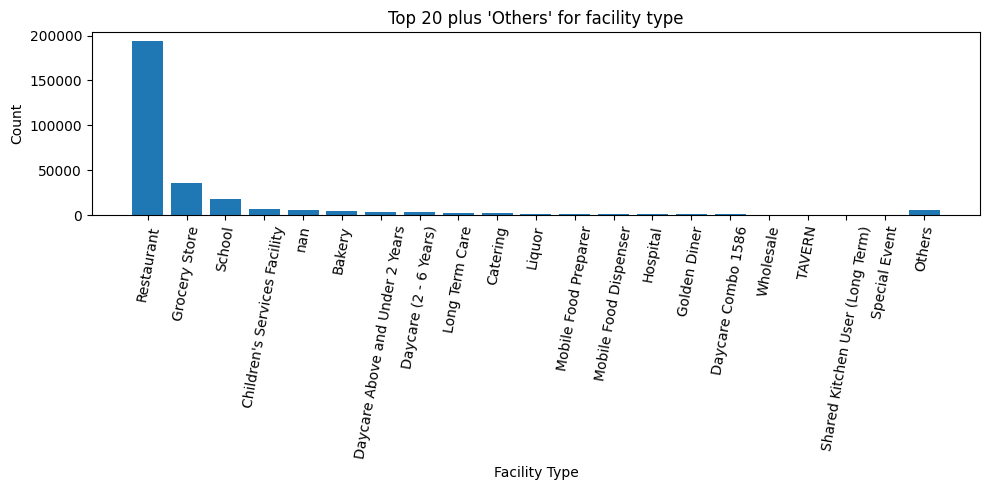

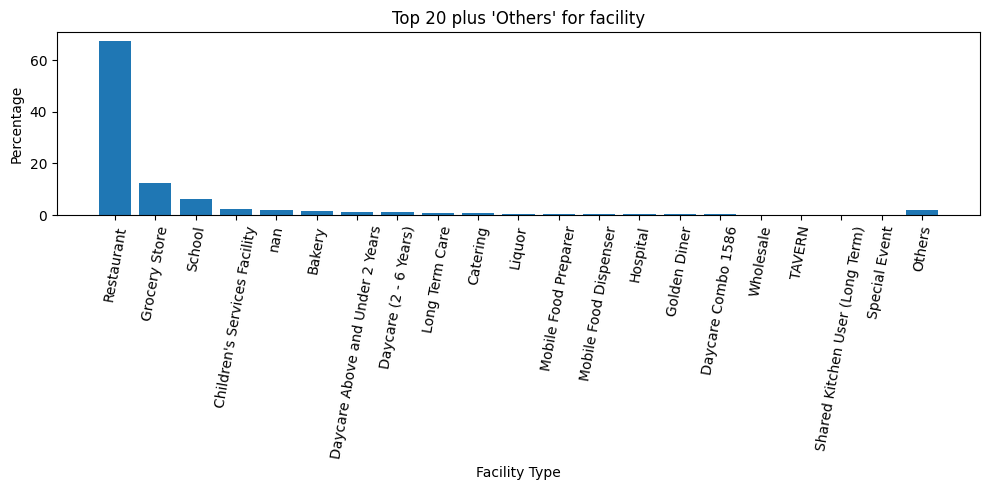

In [89]:
facility_type = freq_dfs['Facility Type']


# Collapsing non-top 20 categories into 'Others':
facility_type_sorted = facility_type.sort_values("Facility Type_count", ascending=False)
total_count = facility_type["Facility Type_count"].sum()


# Slice out top N
N = 20
top_rows = facility_type_sorted.iloc[:N].copy()

# Collapse all remaining categories into one row
if len(facility_type_sorted) > N:
    others = facility_type_sorted.iloc[N:].copy()
    sum_others = others["Facility Type_count"].sum()

   # Create a small DataFrame for the Others row
    others_row = pd.DataFrame({"Facility Type_value": ["Others"], "Facility Type_count": [sum_others]})

    # Concatenate it with top_rows
    top_rows = pd.concat([top_rows, others_row], ignore_index=True)
    top_rows['percentage'] = (top_rows["Facility Type_count"] / total_count) * 100


# Plot
plt.figure(figsize=(10, 5))
plt.bar(top_rows["Facility Type_value"].astype(str), top_rows["Facility Type_count"])
plt.title(f"Top {N} plus 'Others' for facility type")
plt.xlabel("Facility Type")
plt.ylabel("Count")
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.bar(top_rows["Facility Type_value"].astype(str), top_rows["percentage"])
plt.title(f"Top {N} plus 'Others' for facility")
plt.xlabel("Facility Type")
plt.ylabel("Percentage")
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()


Risk

        Risk_value  Risk_count  percentage
0    Risk 1 (High)      211761   73.723441
1  Risk 2 (Medium)       52347   18.224323
2     Risk 3 (Low)       22973    7.997925
3              NaN          88    0.030637
4              All          68    0.023674


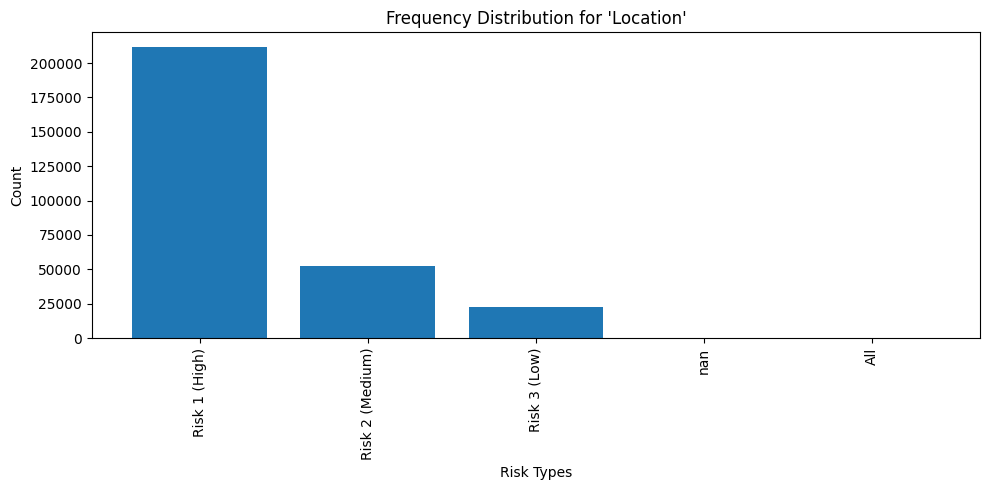

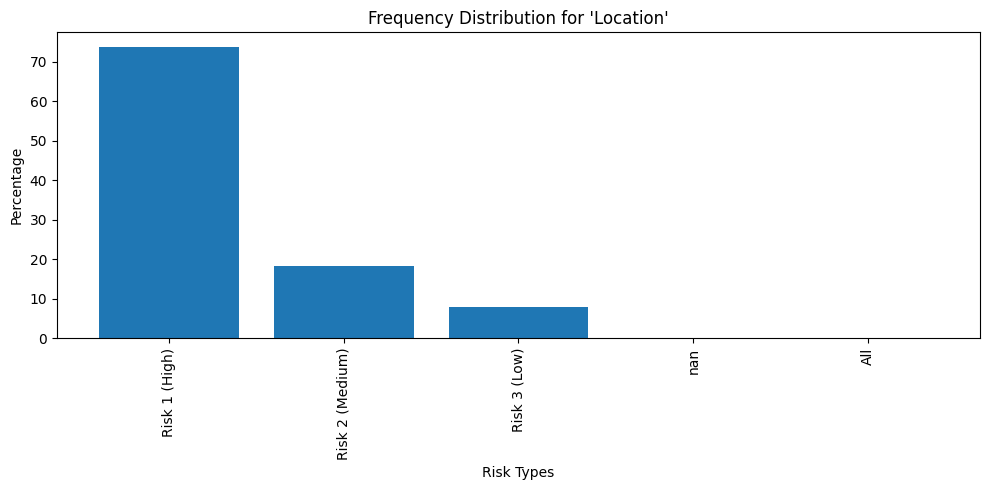

In [91]:
# Plotting Facility Type:
risk = freq_dfs['Risk']

total_count = risk["Risk_count"].sum()
risk['percentage'] = (risk["Risk_count"] / total_count) * 100

print(risk)

plt.figure(figsize=(10, 5))
plt.bar(risk['Risk_value'].astype(str), risk['Risk_count'])
plt.title(f"Frequency Distribution for '{col}'")
plt.xlabel("Risk Types")
plt.ylabel("Count")
plt.xticks(rotation=90)  # rotate x-axis labels if needed
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(risk['Risk_value'].astype(str), risk['percentage'])
plt.title(f"Frequency Distribution for '{col}'")
plt.xlabel("Risk Types")
plt.ylabel("Percentage")
plt.xticks(rotation=90)  # rotate x-axis labels if needed
plt.tight_layout()
plt.show()


City

      City_value  City_count
0        CHICAGO      286102
1        Chicago         448
2            NaN         164
3        chicago         150
4       CCHICAGO          59
..           ...         ...
82      GRIFFITH           1
83      NEW YORK           1
84  NEW HOLSTEIN           1
85     WADSWORTH           1
86     GRAYSLAKE           1

[87 rows x 2 columns]


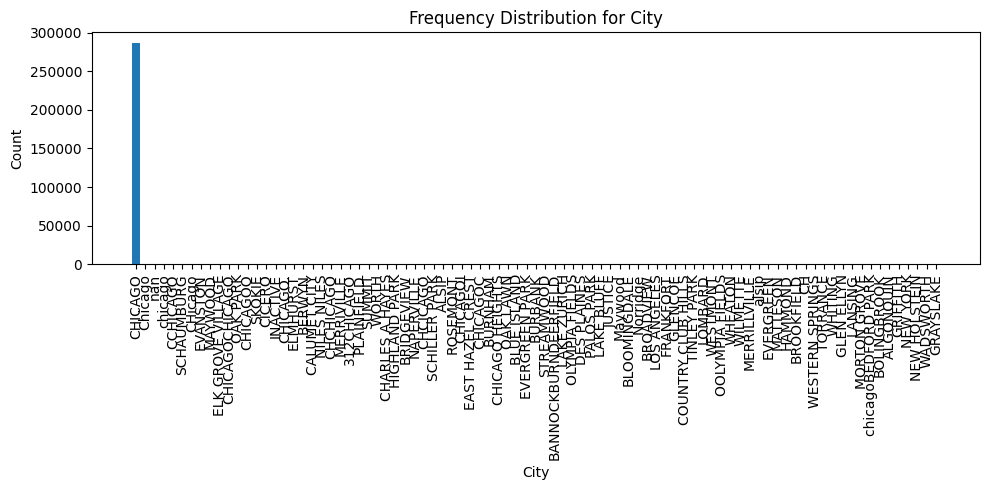

In [58]:
# Plotting Facility Type:
city = freq_dfs['City']
print(city)

plt.figure(figsize=(10, 5))
plt.bar(city['City_value'].astype(str), city['City_count'])
plt.title(f"Frequency Distribution for City")
plt.xlabel("City")
plt.ylabel("Count")
plt.xticks(rotation=90)  # rotate x-axis labels if needed
plt.tight_layout()
plt.show()

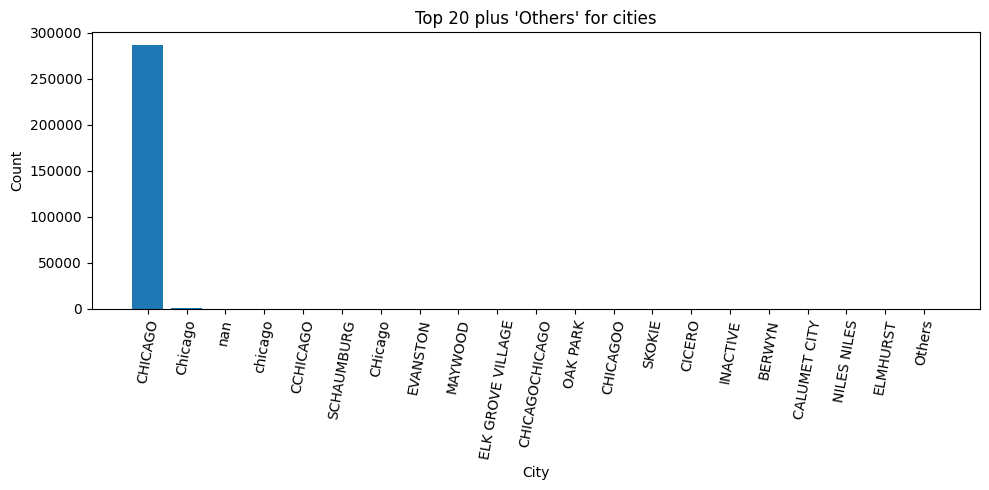

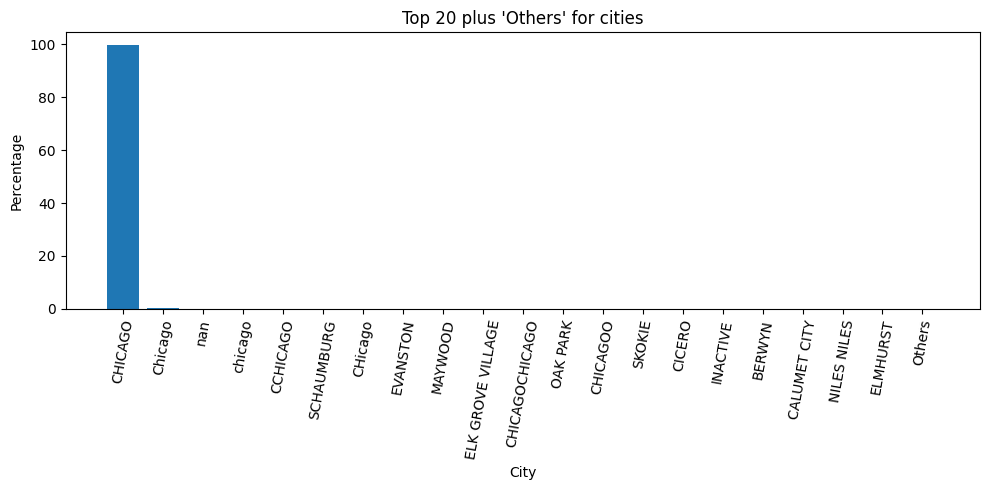

In [84]:
# Plotting top 20 and collapsing others:

city_sorted = city.sort_values("City_count", ascending=False)

# calculate total count
total_count = city_sorted["City_count"].sum()

# Slice out top N
N = 20
top_rows = city_sorted.iloc[:N].copy()

# Collapse all remaining categories into one row
if len(city_sorted) > N:
    others = city_sorted.iloc[N:].copy()
    sum_others = others["City_count"].sum()

   # Create a small DataFrame for the Others row
    others_row = pd.DataFrame({"City_value": ["Others"], "City_count": [sum_others]})

    # Concatenate it with top_rows
    top_rows = pd.concat([top_rows, others_row], ignore_index=True)
    top_rows['percentage'] = (top_rows["City_count"] / total_count) * 100

# Plot
plt.figure(figsize=(10, 5))
plt.bar(top_rows["City_value"].astype(str), top_rows["City_count"])
plt.title(f"Top {N} plus 'Others' for cities")
plt.xlabel("City")
plt.ylabel("Count")
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.bar(top_rows["City_value"].astype(str), top_rows["percentage"])
plt.title(f"Top {N} plus 'Others' for cities")
plt.xlabel("City")
plt.ylabel("Percentage")
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

There are at least 6 possible entries for the same city, for 'Chicago' as seen.

State

  State_value  State_count  percentage
0          IL       287164   99.974585
1         NaN           58    0.020192
2          IN           10    0.003481
3          CA            2    0.000696
4          CO            1    0.000348
5          NY            1    0.000348
6          WI            1    0.000348


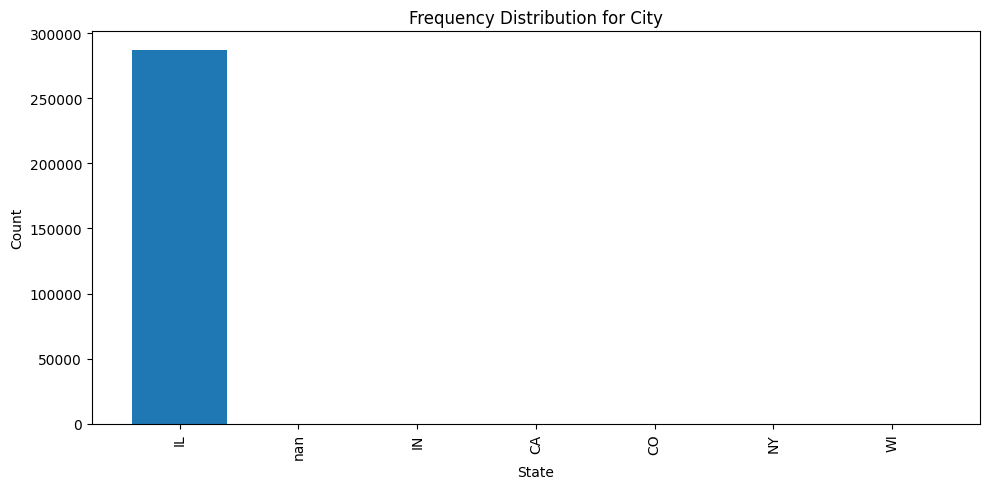

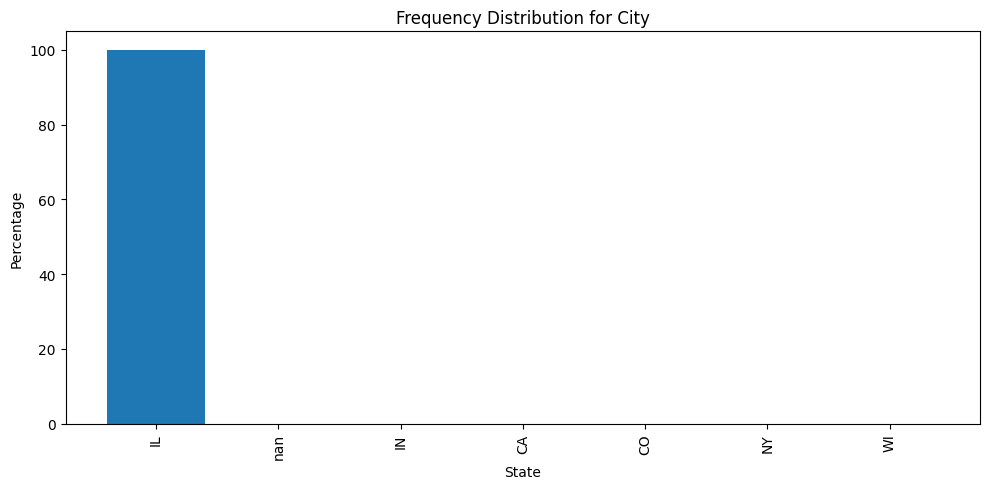

In [92]:
# Plotting Facility Type:
state = freq_dfs['State']
total_count = state["State_count"].sum()
state['percentage'] = (state["State_count"] / total_count) * 100

print(state)

plt.figure(figsize=(10, 5))
plt.bar(state['State_value'].astype(str), state['State_count'])
plt.title(f"Frequency Distribution for City")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)  # rotate x-axis labels if needed
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(state['State_value'].astype(str), state['percentage'])
plt.title(f"Frequency Distribution for City")
plt.xlabel("State")
plt.ylabel("Percentage")
plt.xticks(rotation=90)  # rotate x-axis labels if needed
plt.tight_layout()
plt.show()

Inspection Type

         Inspection Type_value  Inspection Type_count
0                      Canvass                 149444
1                      License                  38171
2        Canvass Re-Inspection                  31876
3                    Complaint                  26934
4        License Re-Inspection                  12005
..                         ...                    ...
106                       FIRE                      1
107          Recent inspection                      1
108                 ASSESSMENT                      1
109               POSSIBLE FBI                      1
110  TASK FORCE PACKAGE LIQUOR                      1

[111 rows x 2 columns]


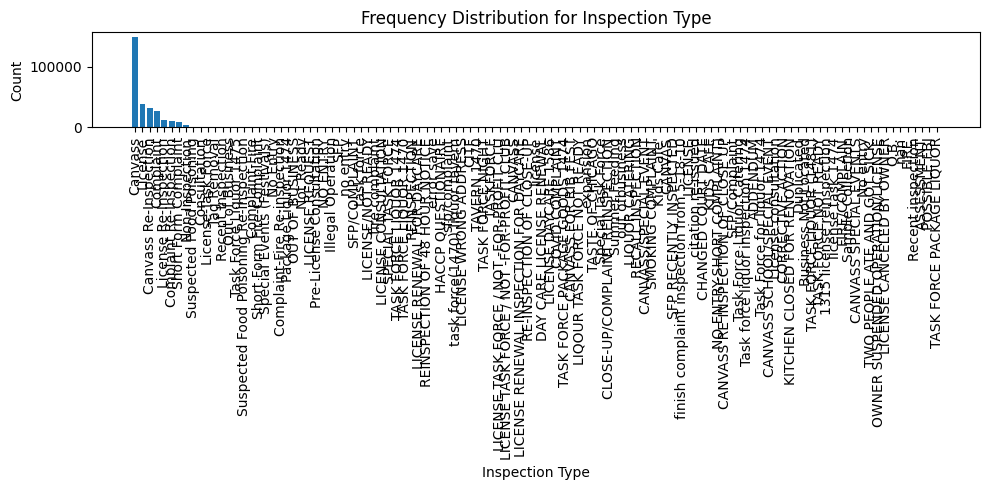

In [67]:
# Plotting Facility Type:
inspection = freq_dfs['Inspection Type']
print(inspection)

plt.figure(figsize=(10, 5))
plt.bar(inspection['Inspection Type_value'].astype(str), inspection['Inspection Type_count'])
plt.title(f"Frequency Distribution for Inspection Type")
plt.xlabel("Inspection Type")
plt.ylabel("Count")
plt.xticks(rotation=90)  # rotate x-axis labels if needed
plt.tight_layout()
plt.show()

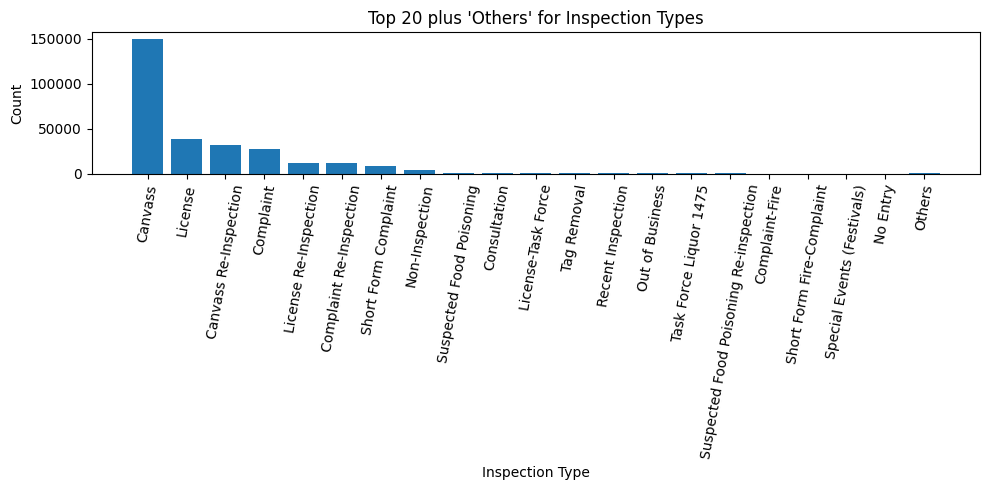

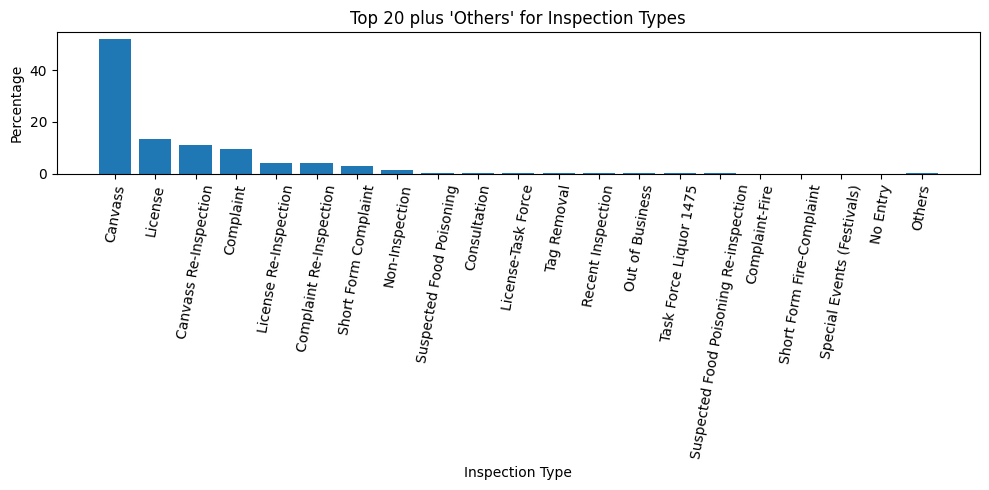

In [93]:
# Plotting top 20 and collapsing others:

inspection_sorted = inspection.sort_values("Inspection Type_count", ascending=False)

# calculate total count
total_count = inspection_sorted["Inspection Type_count"].sum()

# Slice out top N
N = 20
top_rows = inspection_sorted.iloc[:N].copy()

# Collapse all remaining categories into one row
if len(inspection_sorted) > N:
    others = inspection_sorted.iloc[N:].copy()
    sum_others = others["Inspection Type_count"].sum()

   # Create a small DataFrame for the Others row
    others_row = pd.DataFrame({"Inspection Type_value": ["Others"], "Inspection Type_count": [sum_others]})

    # Concatenate it with top_rows
    top_rows = pd.concat([top_rows, others_row], ignore_index=True)
    top_rows['percentage'] = (top_rows["Inspection Type_count"] / total_count) * 100


# Plot
plt.figure(figsize=(10, 5))
plt.bar(top_rows["Inspection Type_value"].astype(str), top_rows["Inspection Type_count"])
plt.title(f"Top {N} plus 'Others' for Inspection Types")
plt.xlabel("Inspection Type")
plt.ylabel("Count")
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(top_rows["Inspection Type_value"].astype(str), top_rows["percentage"])
plt.title(f"Top {N} plus 'Others' for Inspection Types")
plt.xlabel("Inspection Type")
plt.ylabel("Percentage")
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

Results

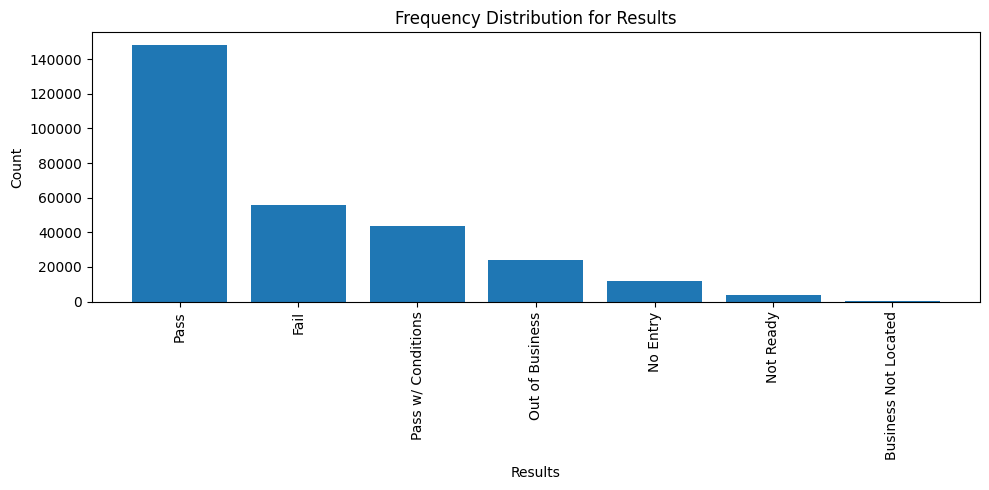

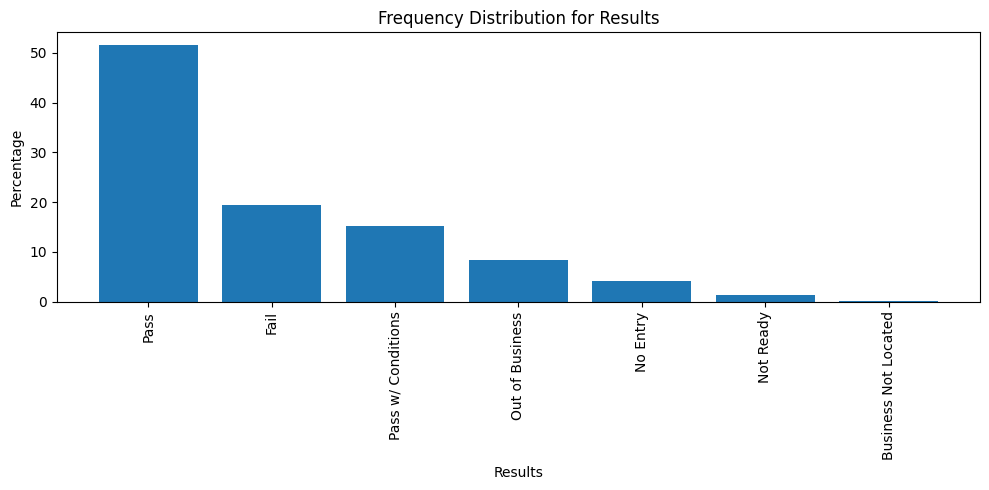

In [94]:
result = freq_dfs['Results']
total_count = result['Results_count'].sum()
result['percentage'] =  (result["Results_count"] / total_count) * 100

plt.figure(figsize=(10, 5))
plt.bar(result['Results_value'].astype(str), result['Results_count'])
plt.title(f"Frequency Distribution for Results")
plt.xlabel("Results")
plt.ylabel("Count")
plt.xticks(rotation=90)  # rotate x-axis labels if needed
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.bar(result['Results_value'].astype(str), result['percentage'])
plt.title(f"Frequency Distribution for Results")
plt.xlabel("Results")
plt.ylabel("Percentage")
plt.xticks(rotation=90)  # rotate x-axis labels if needed
plt.tight_layout()
plt.show()

# Inspection Date Distribution

Earliest Date of Inspection: 01/02/2013
Latest Date of Inspection: 12/31/2024


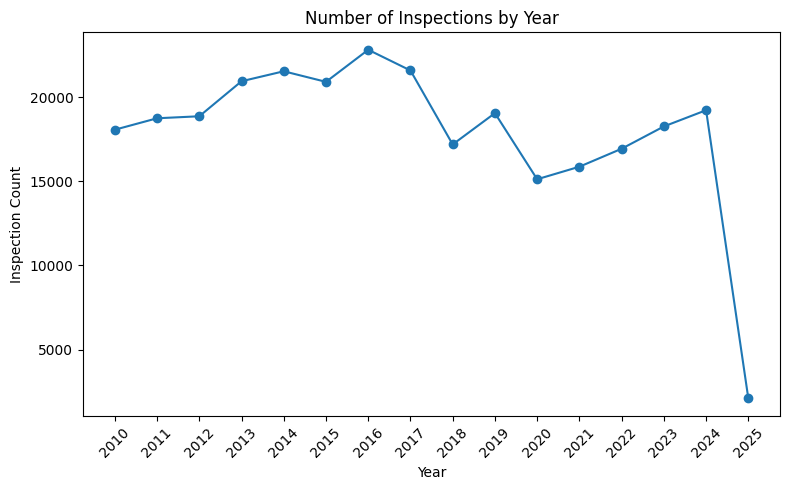

In [100]:
# earliest date
print('Earliest Date of Inspection:',min(df['Inspection Date']))

# latest date:
print('Latest Date of Inspection:', max(df['Inspection Date']))

# yearly inspections distribution:

df["Inspection Date"] = pd.to_datetime(df["Inspection Date"], errors="coerce")

df["Year"] = df["Inspection Date"].dt.year

# 3) Group by year and count how many inspections occurred
year_counts = df.groupby("Year")["Inspection Date"].count()

# 4) Plot as a line chart
plt.figure(figsize=(8, 5))
year_counts.plot(kind="line", marker="o")  # marker='o' to highlight data points
plt.title("Number of Inspections by Year")
plt.xlabel("Year")
plt.ylabel("Inspection Count")
plt.xticks(year_counts.index, rotation=45)  # rotate labels if needed
plt.tight_layout()
plt.show()


# Splitting violations and distributions of violations

In [8]:
violation_test = df['Violations']

In [13]:
import re

def extract_violation_codes(text):
    """
    Given a string like:
        '32. FOOD ... | 32. FOOD ... | 34. FLOORS ... | 35. WALLS ...'
    Split by '|' and parse out the numbers that come before a '.'.
    Returns a set of unique codes, e.g. {'32', '34', '35'}.
    """

    # check if value is non-NA or other none-string types:
    if not isinstance(text, str):
        return set() # empty set
    
    # Split the entire violation text by '|'
    segments = text.split('|')
    
    # Use a regular expression to find something like '32.' at the start
    # or anywhere. We'll capture the digits (e.g., "32") before the period.
    code_pattern = re.compile(r'\b(\d+)\.')
    
    codes = set()
    for seg in segments:
        # Find all matches in each segment
        found = code_pattern.findall(seg)
        for code in found:
            codes.add(code.strip())
    
    return codes

df['Violation_codes'] =violation_test.apply(extract_violation_codes)


In [41]:
df['Violations'][0]


'32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: PROVIDE A DRAIN BOARD AT THREE COMPARTMENT SINK. | 32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: OBSERVED RUSTY GREASE TRAP UNDER THE THREE COMPARTMENT SINK, INSTRUCTED TO PAINT AND MAINTAIN.  PROVIDE SPLASH GUARD BETWEEN THE  EXPOSED HAND SINK ON BOTH SIDE AND PREP COUNTER | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: INSTRUCTED TO SWEEP FLOOR INSIDE THE FURNACE AREA.  OBSERVED AT SECOND FLOOR UNUSED CLASSROOMS WITH ITEMS STORED ON FLOOR, INSTRUCTED TO ELEVATE 6" OFF THE FLOOR,AND ORGANIZE AREA.  RESEAL BASEBOARD UNDER THE THREE COMPARTMENT SINK IN KITCHEN. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: OBSERVED DEAD BULB IN THE KITCHEN, INSTRUCTED TO REPLACE AND PROVIDE LIGHT SH

# columns for fuzzy matching:
- DBA Name
- AKA Name

In [43]:
df

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violation_codes,Violation_code_count
0,1106427,BLOOMING BUD DAYCARE,BLOOMING BUD DAYCARE,2215789.0,Daycare Combo 1586,Risk 1 (High),5715 N LINCOLN AVE,CHICAGO,IL,60659.0,03/07/2013,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.985390,-87.698734,"(41.98538950526786, -87.69873407149943)","{35, 32, 34}",3
1,2608378,Babas Halal,Babas Halal,2684170.0,Restaurant,Risk 1 (High),7901 S DAMEN AVE,CHICAGO,IL,60620.0,12/03/2024,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.750189,-87.672986,"(41.750189342293375, -87.67298583977204)","{41, 22, 21, 61, 201, 50, 10, 20, 204, 101, 50...",28
2,1106406,FIRST ZABIHA MEAT BAZAAR,FIRST ZABIHA MEAT BAZAAR,2232559.0,Grocery Store,Risk 2 (Medium),2907 W DEVON AVE,CHICAGO,IL,60659.0,02/20/2013,License,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.997401,-87.702385,"(41.99740137039031, -87.70238538227812)","{38, 30, 11, 32, 42, 33, 34, 35}",8
3,2609909,HAPPY MARKET,HAPPY MARKET,2912802.0,Grocery Store,Risk 2 (Medium),2334 S WENTWORTH AVE,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.849954,-87.632094,"(41.84995400192252, -87.63209419559098)","{38, 49, 501, 301, 2, 10}",6
4,2609927,SAT KAIVAL FOOD INC/SUBWAY,SAT KAIVAL FOOD INC/SUBWAY,2728400.0,Restaurant,Risk 1 (High),1916 S STATE ST,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.856053,-87.627311,"(41.85605269621059, -87.62731125804903)","{53, 36}",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287232,2610937,DAPPER'S EAST RESTAURANT,DAPPER'S EAST RESTAURANT,12540.0,Restaurant,Risk 1 (High),2901 W ADDISON ST,CHICAGO,IL,60618.0,01/23/2025,Complaint Re-Inspection,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.946553,-87.700536,"(41.94655282616904, -87.700535765616)","{602, 49, 47, 202}",4
287233,2610845,SHARPIE'S,SHARPIE'S,3002203.0,Restaurant,Risk 3 (Low),1721 N ELSTON AVE,CHICAGO,IL,60642.0,01/22/2025,License,Not Ready,NaN,41.913729,-87.664223,"(41.91372879440366, -87.66422290709808)",{},0
287234,2610409,ACE SUSHI @POTASH MARKET,ACE SUSHI,2808766.0,Restaurant,Risk 1 (High),875 N STATE ST,CHICAGO,IL,60610.0,01/13/2025,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.898878,-87.628111,"(41.89887819742381, -87.6281111483033)","{55, 58}",2
287235,2610823,"Kitchen Chicago, LLC","Kitchen Chicago, LLC",2119905.0,Shared Kitchen,Risk 1 (High),324 N LEAVITT ST,CHICAGO,IL,60612.0,01/22/2025,Canvass,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,41.887434,-87.681849,"(41.88743405025222, -87.68184949426895)","{49, 55}",2


id = violation_code
description = 'FOOD AND NON-FOOD CONTACT SURFACES PROPERL...'


In [16]:
# plotting distribution of number of violations:
df['Violation_code_count'] = df['Violation_codes'].apply(len)
print(df['Violation_code_count'].max())
print(df['Violation_code_count'].min())



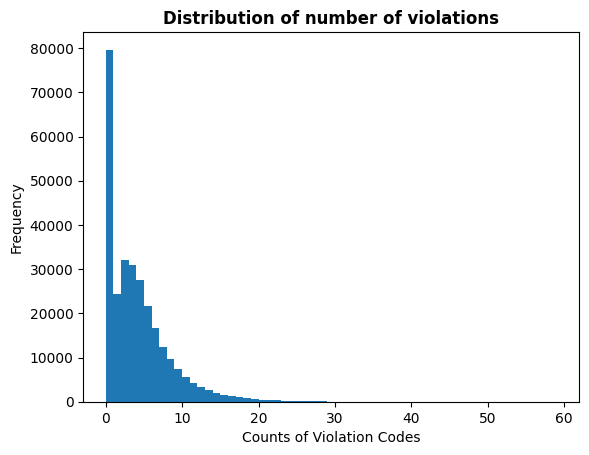

In [32]:

bins_list = list(range(0,60))
plt.hist(df['Violation_code_count'], bins_list)
plt.xlabel('Counts of Violation Codes')
plt.ylabel('Frequency')
plt.title('Distribution of number of violations', fontweight='bold')

plt.show()

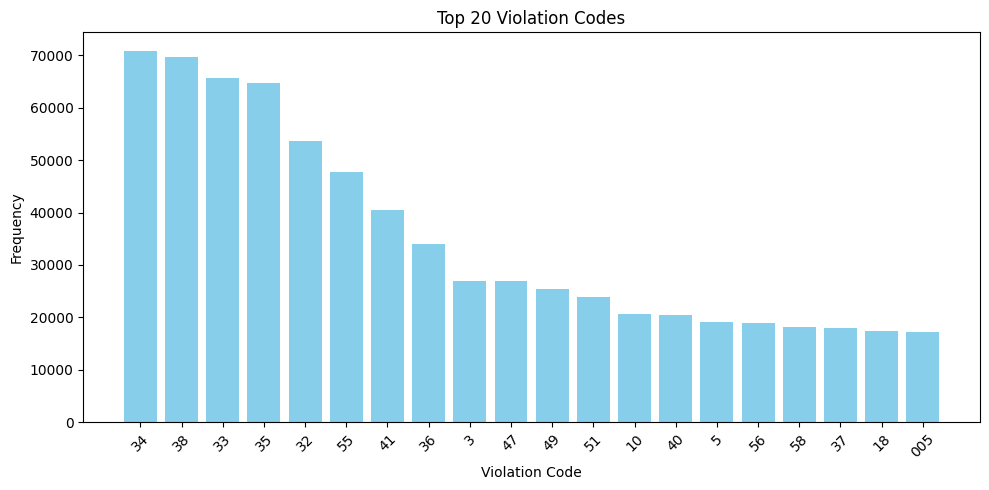

In [33]:
# Finding top 20 violations:
from collections import Counter

# 1) Flatten the sets in 'Violation_codes' into a single list of codes
all_codes = []
for codeset in df['Violation_codes'].dropna():
    all_codes.extend(codeset)  

# 2) Count occurrences of each code
code_counter = Counter(all_codes)

# 3) Get the top 20 and turn them into a DataFrame
top_20 = code_counter.most_common(20)  # returns a list of (code, count) tuples
top_20_df = pd.DataFrame(top_20, columns=["code", "count"])

# 4) Plot as a bar chart
plt.figure(figsize=(10,5))
plt.bar(top_20_df["code"], top_20_df["count"], color="skyblue")
plt.title("Top 20 Violation Codes")
plt.xlabel("Violation Code")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [37]:
# so far: this is how the dataset looks:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violation_codes,Violation_code_count
0,1106427,BLOOMING BUD DAYCARE,BLOOMING BUD DAYCARE,2215789.0,Daycare Combo 1586,Risk 1 (High),5715 N LINCOLN AVE,CHICAGO,IL,60659.0,03/07/2013,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.985390,-87.698734,"(41.98538950526786, -87.69873407149943)","{35, 32, 34}",3
1,2608378,Babas Halal,Babas Halal,2684170.0,Restaurant,Risk 1 (High),7901 S DAMEN AVE,CHICAGO,IL,60620.0,12/03/2024,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.750189,-87.672986,"(41.750189342293375, -87.67298583977204)","{41, 22, 21, 61, 201, 50, 10, 20, 204, 101, 50...",28
2,1106406,FIRST ZABIHA MEAT BAZAAR,FIRST ZABIHA MEAT BAZAAR,2232559.0,Grocery Store,Risk 2 (Medium),2907 W DEVON AVE,CHICAGO,IL,60659.0,02/20/2013,License,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.997401,-87.702385,"(41.99740137039031, -87.70238538227812)","{38, 30, 11, 32, 42, 33, 34, 35}",8
3,2609909,HAPPY MARKET,HAPPY MARKET,2912802.0,Grocery Store,Risk 2 (Medium),2334 S WENTWORTH AVE,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.849954,-87.632094,"(41.84995400192252, -87.63209419559098)","{38, 49, 501, 301, 2, 10}",6
4,2609927,SAT KAIVAL FOOD INC/SUBWAY,SAT KAIVAL FOOD INC/SUBWAY,2728400.0,Restaurant,Risk 1 (High),1916 S STATE ST,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.856053,-87.627311,"(41.85605269621059, -87.62731125804903)","{53, 36}",2


Variables to drop:
- Inspection ID
- 